In [ ]:
from numba.core.cgutils import false_bit

# Fourier Analysis in NT and Markets

In this warmup notebook, we compare the application of Fourier series analysis in Number Theory and market data.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack, signal
from math import log

In [7]:
def von_Mangoldt(N):
    #Return an np.arrey Lambda[0,1,...,N], where Lambda is a simplified von mangoldt function, taking log value on primes. With the convention \Lambda(0)=0
    Lam=np.zeros(N, dtype=float)
    is_prime=np.ones(N+1, dtype=bool)

    for p in range(2, N):
        if not is_prime[p]:
            continue
        is_prime[p*p::p]=0
        Lam[p]=log(p)
    return Lam

np.float64(1.0986122886681098)

By the Prime-Number Theorem, the sum of von Mangoldt up to N should be around N.

In [29]:
N=20000001
Lambda=von_Mangoldt(N)
print("N:", N, "sum Lambda:", Lambda.sum())

N: 20000001 sum Lambda: 19995840.88215298


We next calculate $\hat{\Lambda}(\alpha)=\sum_{n\leq N}\Lambda(n) e^{2\pi i \alpha n}$

In [17]:
def hat(Array):
    #Simple fft that return alpha value and fourier transform. No padding or hann window.
    N=len(Array)
    alphas=np.arange(N)/N
    X=fftpack.fft(Array)
    return alphas, X

alphas, X=hat(Lambda)

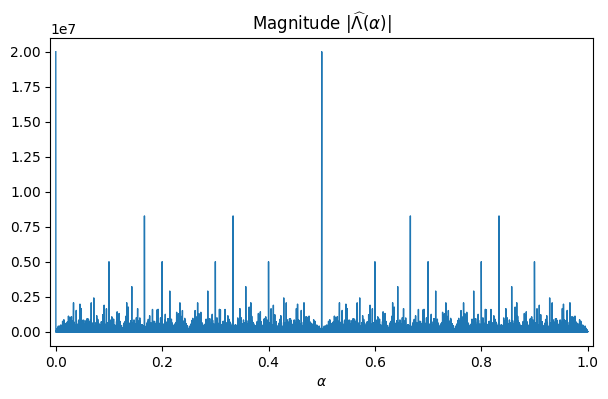

In [27]:
def plot_spectrum(alphas, X, zoom_max=0.1, logscale=False):
    mag=np.abs(X)
    plt.figure(figsize=(7,4))
    plt.plot(alphas, mag, lw=1)
    plt.xlim(-0.01, 1.01)
    plt.xlabel(r'$\alpha$')
    plt.title(r'Magnitude $|\widehat{\Lambda}(\alpha)|$')
    plt.show()

plot_spectrum(alphas, X, zoom_max=0.05)

We know that $|\hat{\Lambda}(\alpha)|$ should be of size $N/q$ if $\alpha$ is close to a rational number with denominator $q$. Let's extract this information numerically.

In [47]:

def large_spec(alphas, X, rel_size=0.01):
    mag=np.abs(X)
    thresh = rel_size * float(mag.max())
    large= mag > thresh
    padded=np.r_[0, large.view(np.int8), 0] #reinterpret as int values, and add 0 at beginning and end
    diff= np.diff(padded)  #Differentiate to discover runs
    starts= np.where(diff == 1)[0]
    ends= np.where(diff == -1)[0]
    sel_indices = []
    for s, e in zip(starts, ends):
        # choose index of max magnitude inside cluster
        cluster_idx = np.arange(s, e)
        local_idx = cluster_idx[np.argmax(mag[cluster_idx])]
        sel_indices.append(int(local_idx))
    sel_indices = np.array(sel_indices, dtype=int)
    order = np.argsort(-np.abs(X[sel_indices]))
    sel_indices = sel_indices[order]
    return alphas[sel_indices], X[sel_indices]


largalpha, largeX= large_spec(alphas, X)
largalpha[20]

np.float64(0.7857143)